# Experiments with synthetic data

This notebook reproduces Figures 2, 3 in the paper. It requires output files generated by executing the scripts `scripts/synth_compute_cf_mdps.sh` and `scripts/synth_experiment.sh`.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
from src.synth_mdp import Synth_MDP
from scipy.stats import entropy

sns.set_theme(context='paper', style='ticks', font_scale=1)

In [3]:
width_pt = 397
palette = sns.color_palette('husl', 7)
type_dict = {
    'cf_entropy' : float,
    'mdp_entropy' : float,
    'id' : int,
    'k' : int,
    'avg_cf_outcome' : float,
    'num_of_explanations' : int
}

In [4]:
files = glob.glob("./outputs/synth_*.json")

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        dicts.append(js)

input_df = pd.DataFrame(dicts)

Reading file 63000/63000


In [5]:
data_df = input_df.astype(type_dict) # Fix types
data_df = data_df.rename(columns={'mdp_entropy': 'Original entropy', 'cf_entropy': 'Counterfactual entropy', 'avg_cf_outcome' : 'Average counterfactual outcome', 'num_of_explanations' : 'Number of counterfactual explanations'}) # Rename columns

In the following cell, set the value of the parameter `k` for Figure 2. In the paper, we present results under `k = 2, 5, 10`.

In [ ]:
kap = 2

In [45]:
alph = 0.1

temp_df = data_df[data_df['alpha']==alph]
init_df = temp_df[temp_df['k']==0].set_index(['id','param_seed'])
improved_df = temp_df[temp_df['k']==kap].set_index(['id', 'param_seed'])
comp_df = init_df
comp_df['Average counterfactual improvement'] = (improved_df['Average counterfactual outcome'] - init_df['Average counterfactual outcome'])/init_df['Average counterfactual outcome']*100

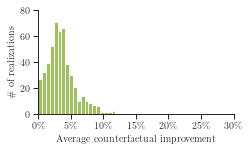

In [46]:
utils.latexify(font_size=10, legend_font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.histplot(data=comp_df, x="Average counterfactual improvement", color=palette[2], stat='count', ax=ax)
sns.despine()

ax.set_xlim(left=0, right=30)
ax.set_ylim(top=80)
ax.set_ylabel(r'\# of realizations')
ax.set_xlabel('Average counterfactual improvement')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))


fig.tight_layout()
fig.savefig('figures/synth_distribution_alph_{alph}_kap_{kap}.pdf'.format(alph=int(alph*10), kap=kap))

In [47]:
kapas = [2, 5, 10]
init_df = data_df[data_df['k']==0].set_index(['id','param_seed', 'alpha'])
total_df = [] 
for kap in kapas:
    improved_df = data_df[data_df['k']==kap].set_index(['id', 'param_seed', 'alpha'])
    comp_df = improved_df
    comp_df['Average counterfactual improvement'] = (improved_df['Average counterfactual outcome'] - init_df['Average counterfactual outcome'])/init_df['Average counterfactual outcome']*100
    comp_df.reset_index(level='alpha', inplace=True)
    total_df.append(comp_df)


In [48]:
comp_df = pd.concat(total_df)

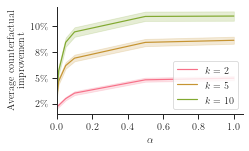

In [49]:
utils.latexify(font_size=10, legend_font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.lineplot(data=comp_df, x='alpha', y='Average counterfactual improvement', hue='k', palette=palette[:3], err_style='band', ax=ax)
sns.despine()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_ylabel('Average counterfactual\n improvement')
ax.set_xlabel(r'$\alpha$')
ax.set_xlim(left=0)
ax.legend(labels=[r'$k={kap}$'.format(kap=kap) for kap in kapas], loc='lower right')

fig.tight_layout()
fig.savefig('figures/synth_improv_vs_alpha.pdf')

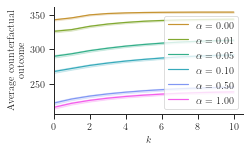

In [54]:
utils.latexify(font_size=10, legend_font_size=10)

alphas = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0]
temp_df = data_df[(data_df['alpha']==0.0) | (data_df['alpha']==0.01) | (data_df['alpha']==0.05) | (data_df['alpha']==0.1) 
                    | (data_df['alpha']==0.5) | (data_df['alpha']==1.0)]
temp_df = temp_df[(temp_df['k']<=10)]
fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.lineplot(data=temp_df, x='k', y='Average counterfactual outcome', hue='alpha', palette=palette[1:],
            err_style='band', ax=ax)
sns.despine()

ax.legend(labels=[r'$\alpha={alpha}$'.format(alpha="{:.2f}".format(alpha)) for alpha in alphas], loc='lower right')
ax.set_xlim(left=0)
ax.set_xlabel(r'$k$')
ax.set_ylabel('Average counterfactual\n outcome')

fig.tight_layout()
fig.savefig('figures/synth_outcome_vs_k_vs_alpha.pdf')

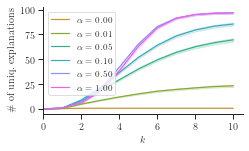

In [52]:
utils.latexify(font_size=10)

temp_df = data_df[(data_df['alpha']==0.0) | (data_df['alpha']==0.01) | (data_df['alpha']==0.05) | (data_df['alpha']==0.1) 
                    | (data_df['alpha']==0.5) | (data_df['alpha']==1.0)]
temp_df = temp_df[(temp_df['k']<=10)]
fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.lineplot(data=temp_df, x='k', y='Number of counterfactual explanations', hue='alpha', palette=palette[1:],
            err_style='band', ax=ax)
sns.despine()

ax.legend(labels=[r'$\alpha={alpha}$'.format(alpha="{:.2f}".format(alpha)) for alpha in alphas], loc='upper left')
ax.set_xlim(left=0)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'\# of uniq. explanations')

fig.tight_layout()
fig.savefig('figures/synth_expl_vs_k_vs_alpha.pdf')